## PROJET STT-3795 | Système de recommendation

### Prise en main du dataset

Dans un premier temps, nous allons récupérer nos données et afficher quelques statistiques de base du jeux de données. Cela nous permettra de nous familiariser avec les données avant le pré-traitement.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# chargement et expemple des données
data = pd.read_csv(
    "ml-100k/u.data", sep=None, engine='python' ,
    names=['userid', 'movieid', 'rating', 'timestamp']
    )
data.head(5)

,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
# les statistiques de base
data.describe()
# les notes des films sont entre 1 et 5 la moyenne à 3.53/5
# il a 943 users
# et 1682 films notés

In [16]:
# les informations sur les films : titre, date, genres
# liste des 17 genres
genre = pd.read_csv("ml-100k/u.genre", sep='|', names=['genre', 'genreid'])['genre'].values
print(genre)
attribut_item = ['movieid', 'title', 'date','video_date', 'imdb_url']+list(genre)

item = pd.read_csv("ml-100k/u.item", encoding='latin1', sep='|', names=attribut_item)
print(item[list(genre)].sum())
item.head(5)

#item.describe()
# il y a des NaN dans toute la colonne video_date
# tous les genres sont représentés au moins une fois
# mais les genres les plus représentés sont Drama, Comedy, Action et Thriller
# on a bien les 1682 films comme dans data



['unknown' 'Action' 'Adventure' 'Animation' "Children's" 'Comedy' 'Crime'
 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'Musical' 'Mystery'
 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']
unknown          2
Action         251
Adventure      135
Animation       42
Children's     122
Comedy         505
Crime          109
Documentary     50
Drama          725
Fantasy         22
Film-Noir       24
Horror          92
Musical         56
Mystery         61
Romance        247
Sci-Fi         101
Thriller       251
War             71
Western         27
dtype: int64


,movieid,title,date,video_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
# les informations sur les personnes interrogées : age, genre, métier, code postale 
# (US je pense car le dataset vient de l'Université du Minnesota)
# liste des 21 occupations
occupation = pd.read_csv("ml-100k/u.occupation", header=None).values # vecteur contenant les occupations
# print(len(occupation))

user = pd.read_csv("ml-100k/u.user", sep='|', names=['userid', 'age', 'gender', 'occupation', 'zipcode'])
user.head(5)
# essayer de se servir de l'age pour recommandation ou genre ou type d'emploi ???

,userid,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Nettoyage et pré-traitement des données

Dans cette partie, nous allons trier les informations et garder celles qui nous intéressent pour notre système de recommandations.  
Aussi, nous allons ajouter de nouvelles caractéristiques utiles à notre projet.

In [18]:
# Création d'une nouvelle table de données à partir de data et de item
movie_data = pd.merge(data[['userid', 'movieid', 'rating']], item[['movieid', 'title']+list(genre)], on='movieid').sort_values('movieid')
movie_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(5)
movie_data[['title', 'userid', 'rating']+list(genre)].head(5)

movie_data.head()


,userid,movieid,rating,title,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
25741,84,1,2,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
93639,806,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
55726,768,1,5,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
49529,92,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
89079,419,1,4,Toy Story (1995),0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Créer une nouvelle table avec les genres, notes moyennes et nombre de notes selon les titres de films 
item_rating_genre = pd.DataFrame()
item_rating_genre['title'] = pd.DataFrame(movie_data.groupby('movieid')['title'].max())
item_rating_genre['rating_mean'] = pd.DataFrame(movie_data.groupby('movieid')['rating'].mean())
item_rating_genre['rating_counts'] = pd.DataFrame(movie_data.groupby('movieid')['rating'].count())
item_rating_genre[list(genre)] = pd.DataFrame(movie_data.groupby('movieid')[list(genre)].mean()) # moyenne de 0 et de 1 conserve la structure des genres
#item_rating_genre['title'] = pd.DataFrame(movie_data.groupby('movieid')['title'].max())
# on est revenu là, après l'algorithme pour ajouter le movieid
#item_rating_genre['movieid'] = pd.DataFrame(movie_data.groupby('movieid')['movieid'].max()) # max du même movieid conserve le bon movieid

#item_rating_genre['title'] = item_rating_genre.index
#item_rating_genre.index = ((range(len(item_rating_genre))))
item_rating_genre = item_rating_genre.sort_values('movieid')

item_rating_genre.head(5)


,title,rating_mean,rating_counts,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),3.878319,452,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,GoldenEye (1995),3.206107,131,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Four Rooms (1995),3.033333,90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Get Shorty (1995),3.550239,209,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Copycat (1995),3.302326,86,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Analyse Exploratoire des Données

Dans cette partie nous allons analyser les données, observer leur distribution et les effets de corrélations.  
Ceci dans le but de déterminer si les informations sont importantes et pour prévenir les biais des valeurs aberrantes.

Text(0.5, 1.0, 'Distribution du nombre de notes par films')

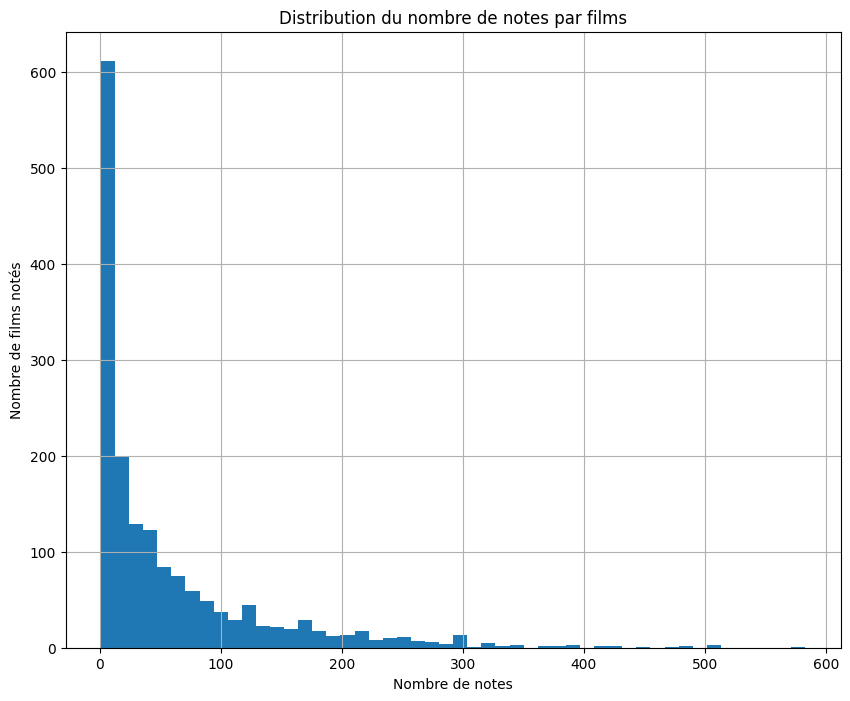

In [27]:
# On remarque que beacoup de films ont reçus très peu de notes
# Il est donc important de prendre en compte la différence entre le nombre de notes reçues
plt.figure(figsize=(10,8))
item_rating_genre['rating_counts'].hist(bins=50)
plt.xlabel('Nombre de notes')
plt.ylabel('Nombre de films notés')
plt.title('Distribution du nombre de notes par films')
#plt.savefig('distrib_nb_notes.png')

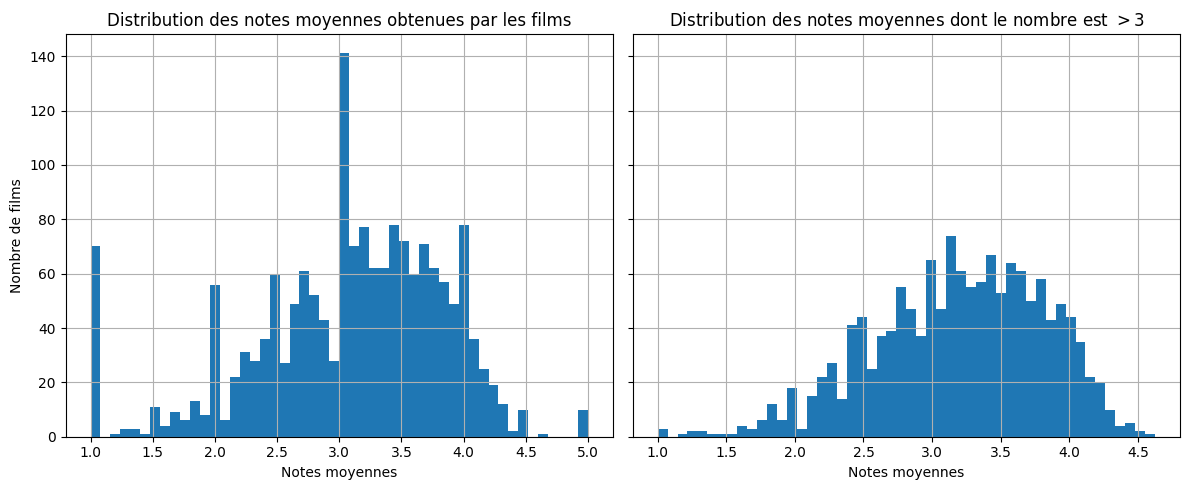

In [20]:
# Ici on observe la distribution des notes moyennes des films
# on remarque une distribution plus ou moins normale centrée sur 3.5
# Mais on surtout qu'il y a beaucoup de notes sur les valeurs entières 1, 2, 3, 4, 5
# cela doit venir des films peu noté qui restent donc avec une moyenne entière
k = 3 # rien qu'en supprimant les notes moyennes basées sur 3 notes et moins on voit que cet effet est limité
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
item_rating_genre['rating_mean'].hist(bins=50,ax=ax[0])
item_rating_genre[item_rating_genre.loc[:, 'rating_counts'] > k]['rating_mean'].hist(bins=50, ax=ax[1])
ax[0].set_xlabel('Notes moyennes')
ax[0].set_ylabel('Nombre de films')
ax[0].set_title('Distribution des notes moyennes obtenues par les films')
ax[1].set_xlabel('Notes moyennes')
ax[1].set_title(f'Distribution des notes moyennes dont le nombre est $>{k}$')

plt.tight_layout()
#plt.savefig('distrib_notes_moy.png')

<Figure size 1000x800 with 0 Axes>

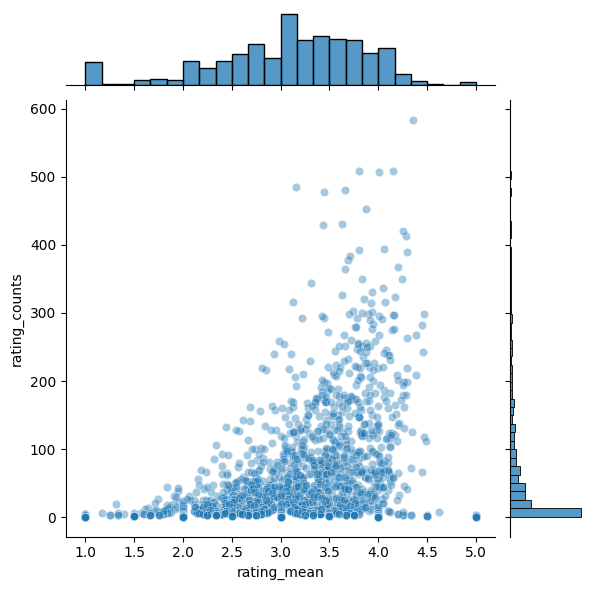

In [21]:
# Avec ce graphique, on remarque que les films avec beaucoup de notes, sont plutôt bien notés
# Et aussi qu'on a une niche de films avec une notes de 5/5 qui ont très peu de notes
# En revenant aux deux graphiques précédents, on remarque que ces films sont présents à gauche, pile sur la note de 5/5
# mais pas à droite, cela veut dire que ces films comptent 3 avis ou moins, il faudra s'en méfier ce sont des valeurs aberrantes 
plt.figure(figsize=(10,8))
sns.jointplot(x='rating_mean', y='rating_counts', data=item_rating_genre, alpha=0.4)
#plt.savefig('jointplot.png')